<a href="https://colab.research.google.com/github/rlaskarl77/MIPAL-animation/blob/nam/AnimationWithViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 데이터 준비
데이터셋은 https://www.kaggle.com/chaerink/project-ae/data 에서 다운로드 후 google drive에 저장.

In [1]:
from google.colab import drive
import os

# 파일 저장되어 있는 경로 지정
DRIVE_PATH = '/content/drive/'
FOLDER_PATH = '/content/drive/MyDrive/MIPAL/Frame Interpolation'
DATA_PATH = '/content/data'

drive.mount(DRIVE_PATH)

Mounted at /content/drive/


In [2]:
%cd $FOLDER_PATH
%ls

/content/drive/MyDrive/MIPAL/Frame Interpolation
 AnimationWithViT.ipynb   LionKing.zip  'Tom&Jerry'/
 LionKing/                runs/         'Tom&Jerry.zip'


In [3]:
# unzip files

!mkdir $DATA_PATH
!mkdir $DATA_PATH/LionKing
!mkdir $DATA_PATH/Tom\&Jerry

%ls $DATA_PATH

!unzip -qq 'LionKing.zip' -d $DATA_PATH/LionKing
!unzip -qq 'Tom&Jerry.zip' -d $DATA_PATH/Tom\&Jerry

 LionKing/  'Tom&Jerry'/


In [4]:
# count check

%ls $DATA_PATH/LionKing | wc -l    #36000
%ls $DATA_PATH/Tom\&Jerry | wc -l   #30000

36000
30000


In [5]:
import numpy as np
import random
import warnings
warnings.filterwarnings('ignore')
import glob
from PIL import Image
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.distributions import kl_divergence
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as dset
import torchvision.utils as vutils
from torchvision.utils import make_grid
import pandas as pd
from IPython.display import HTML
from tqdm.auto import tqdm
from torchvision.models import inception_v3
from torch.cuda.amp import GradScaler, autocast

In [6]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [7]:
!cat /proc/cpuinfo
!nvidia-smi

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	:

In [8]:
torch.cuda.get_device_name(0)

'Tesla K80'

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
def show_images(img, num_images=8, size=(3, 64, 64), nrow=4, figsize=8):
  img = img.cpu().detach().clone().add_(1).div_(2)
  image_grid = make_grid(img[:num_images], nrow=nrow)
  plt.figure(figsize=(figsize, figsize))
  plt.imshow(image_grid.permute(1, 2, 0).squeeze())
  plt.show()

In [11]:
batch_size = 8
image_size = 256
lr = 2e-4

In [12]:
def to_rgb(img):
    rgb_img = Image.new("RGB", img.size)
    rgb_img.paste(img)
    return rgb_img

class ImageSet(Dataset):
    def __init__(self, transform):
        self.transform = transform
        self.imgs = sorted(glob.glob(os.path.join(DATA_PATH, "LionKing", "*.*"))) # Only LionKing
        
    def __getitem__(self, index):
        img = Image.open(self.imgs[index % len(self.imgs)])
        img = to_rgb(img)
        img = self.transform(img)
        return img
    
    def __len__(self):
        return len(self.imgs)

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


dataset = ImageSet(transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

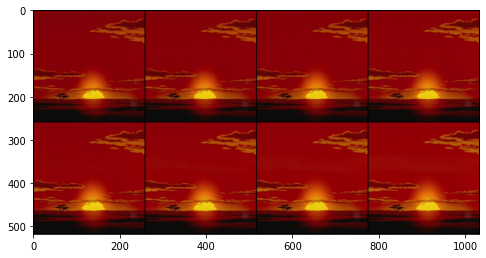

In [13]:
real_batch = next(iter(dataloader))
show_images(real_batch)

# 2. VQ-VQE
데이터셋을 가공해 8장의 이미지가 연속하는 sequence만 포함하도록 만들어야 한다. 아무 종류의 AE를 사용해도 무방하지만 ViT의 이미지 토큰을 생성하기 위해서 VQ-VAE를 이용한다.
코드는 https://github.com/ritheshkumar95/pytorch-vqvae 를 참고했다.

In [14]:
def to_scalar(arr):
    if type(arr) == list:
        return [x.item() for x in arr]
    else:
        return arr.item()


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        try:
            nn.init.xavier_uniform_(m.weight.data)
            m.bias.data.fill_(0)
        except AttributeError:
            print("Skipping initialization of ", classname)

In [15]:
from torch.autograd import Function

class VectorQuantization(Function):
    @staticmethod
    def forward(ctx, inputs, codebook):
        with torch.no_grad():
            embedding_size = codebook.size(1)
            inputs_size = inputs.size()
            inputs_flatten = inputs.view(-1, embedding_size)

            codebook_sqr = torch.sum(codebook ** 2, dim=1)
            inputs_sqr = torch.sum(inputs_flatten ** 2, dim=1, keepdim=True)

            # Compute the distances to the codebook
            distances = torch.addmm(codebook_sqr + inputs_sqr,
                inputs_flatten, codebook.t(), alpha=-2.0, beta=1.0)

            _, indices_flatten = torch.min(distances, dim=1)
            indices = indices_flatten.view(*inputs_size[:-1])
            ctx.mark_non_differentiable(indices)

            return indices

    @staticmethod
    def backward(ctx, grad_output):
        raise RuntimeError('Trying to call `.grad()` on graph containing '
            '`VectorQuantization`. The function `VectorQuantization` '
            'is not differentiable. Use `VectorQuantizationStraightThrough` '
            'if you want a straight-through estimator of the gradient.')

class VectorQuantizationStraightThrough(Function):
    @staticmethod
    def forward(ctx, inputs, codebook):
        indices = vq(inputs, codebook)
        indices_flatten = indices.view(-1)
        ctx.save_for_backward(indices_flatten, codebook)
        ctx.mark_non_differentiable(indices_flatten)

        codes_flatten = torch.index_select(codebook, dim=0,
            index=indices_flatten)
        codes = codes_flatten.view_as(inputs)

        return (codes, indices_flatten)

    @staticmethod
    def backward(ctx, grad_output, grad_indices):
        grad_inputs, grad_codebook = None, None

        if ctx.needs_input_grad[0]:
            # Straight-through estimator
            grad_inputs = grad_output.clone()
        if ctx.needs_input_grad[1]:
            # Gradient wrt. the codebook
            indices, codebook = ctx.saved_tensors
            embedding_size = codebook.size(1)

            grad_output_flatten = (grad_output.contiguous()
                                              .view(-1, embedding_size))
            grad_codebook = torch.zeros_like(codebook)
            grad_codebook.index_add_(0, indices, grad_output_flatten)

        return (grad_inputs, grad_codebook)

vq = VectorQuantization.apply
vq_st = VectorQuantizationStraightThrough.apply

In [16]:
class VQEmbedding(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.embedding = nn.Embedding(K, D)
        self.embedding.weight.data.uniform_(-1./K, 1./K)

    def forward(self, z_e_x):
        z_e_x_ = z_e_x.permute(0, 2, 3, 1).contiguous()
        latents = vq(z_e_x_, self.embedding.weight)
        return latents

    def straight_through(self, z_e_x):
        z_e_x_ = z_e_x.permute(0, 2, 3, 1).contiguous()
        z_q_x_, indices = vq_st(z_e_x_, self.embedding.weight.detach())
        z_q_x = z_q_x_.permute(0, 3, 1, 2).contiguous()

        z_q_x_bar_flatten = torch.index_select(self.embedding.weight,
            dim=0, index=indices)
        z_q_x_bar_ = z_q_x_bar_flatten.view_as(z_e_x_)
        z_q_x_bar = z_q_x_bar_.permute(0, 3, 1, 2).contiguous()

        return z_q_x, z_q_x_bar

In [17]:
class ResBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(dim, dim, 3, 1, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.Conv2d(dim, dim, 1),
            nn.BatchNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)

In [89]:
class VectorQuantizedVAE(nn.Module):
    def __init__(self, input_dim, dim, K=512):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim, dim, 4, 2, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.Conv2d(dim, dim, 4, 2, 1),
            ResBlock(dim),
            # ResBlock(dim),
        )

        self.codebook = VQEmbedding(K, dim)

        self.decoder = nn.Sequential(
            # ResBlock(dim),
            ResBlock(dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(dim, dim, 4, 2, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(dim, input_dim, 4, 2, 1),
            nn.Tanh()
        )

        self.apply(weights_init)

    def encode(self, x):
        z_e_x = self.encoder(x)
        latents = self.codebook(z_e_x)
        return latents

    def decode(self, latents):
        z_q_x = self.codebook.embedding(latents).permute(0, 3, 1, 2)  # (B, D, H, W)
        x_tilde = self.decoder(z_q_x)
        return x_tilde

    def forward(self, x):
        z_e_x = self.encoder(x)
        z_q_x_st, z_q_x = self.codebook.straight_through(z_e_x)
        x_tilde = self.decoder(z_q_x_st)
        return x_tilde, z_e_x, z_q_x

In [19]:
from torch.utils.tensorboard import SummaryWriter

In [90]:
def train(data_loader, model, optimizer, writer, beta, steps):
  model.train()
  for images in tqdm(data_loader, total=len(data_loader)):
    images = images.to(device)

    optimizer.zero_grad()
    x_tilde, z_e_x, z_q_x = model(images)

    # Reconstruction loss
    loss_recons = F.mse_loss(x_tilde, images)
    # Vector quantization objective
    loss_vq = F.mse_loss(z_q_x, z_e_x.detach())
    # Commitment objective
    loss_commit = F.mse_loss(z_e_x, z_q_x.detach())

    loss = loss_recons + loss_vq + beta * loss_commit
    loss.backward()

    # Logs
    writer.add_scalar('loss/vqvae/train/reconstruction', loss_recons.item(), steps)
    writer.add_scalar('loss/vqvae/train/quantization', loss_vq.item(), steps)

    optimizer.step()
    steps += 1

In [91]:
def test(data_loader, model, steps, writer):
  model.eval()
  with torch.no_grad():
    loss_recons, loss_vq = 0., 0.
    for images in tqdm(data_loader, total=len(data_loader)):
      images = images.to(device)
      x_tilde, z_e_x, z_q_x = model(images)
      loss_recons += F.mse_loss(x_tilde, images)
      loss_vq += F.mse_loss(z_q_x, z_e_x)

    loss_recons /= len(data_loader)
    loss_vq /= len(data_loader)

  # Logs
  writer.add_scalar('loss/test/reconstruction', loss_recons.item(), steps)
  writer.add_scalar('loss/test/quantization', loss_vq.item(), steps)

  return loss_recons.item(), loss_vq.item()

In [62]:
def generate_samples(images, model):
  with torch.no_grad():
    images = images.to(device)
    x_tilde, _, _ = model(images)
  return x_tilde

In [32]:
writer = SummaryWriter()
model = VectorQuantizedVAE(3, 128).to(device)

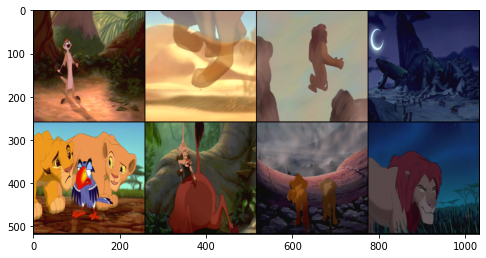

In [33]:
real_batch = next(iter(DataLoader(dataset, batch_size=batch_size, shuffle=True)))
show_images(real_batch)

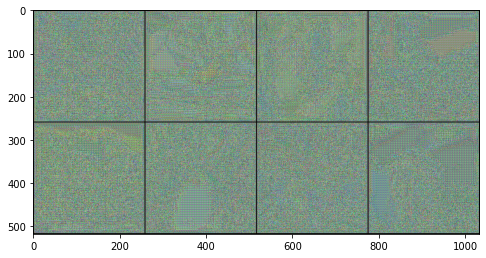

In [34]:
show_images(generate_samples(real_batch.detach().clone(), model))

In [95]:
train_size = int(0.6 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size * 2, shuffle=True)

In [37]:
from torchvision.utils import save_image, make_grid


fixed_images = next(iter(test_loader))
fixed_grid = make_grid(fixed_images, nrow=8, range=(-1, 1), normalize=True)
writer.add_image('original', fixed_grid, 0)
reconstruction = generate_samples(fixed_images, model)
grid = make_grid(reconstruction.cpu(), nrow=8, range=(-1, 1), normalize=True)
writer.add_image('reconstruction', grid, 0)

In [93]:
num_channels = 3
hidden_size = 256
k = 32
lr = 1e-3

model = VectorQuantizedVAE(num_channels, hidden_size, k).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [102]:
best_loss = -1.
steps = 0
beta = [0.5, 1][0]
num_epochs = 1
output_folder = 'vq-vae_lr-{0}_beta-{1}_k-{2}_d-{3}/'.format(lr, beta, k, hidden_size)

save_filename = './models/{0}'.format(output_folder)

if not os.path.exists('./models'):
  os.mkdir('./models')
if not os.path.exists(save_filename):
  os.mkdir(save_filename)

for epoch in range(num_epochs):
  train(train_loader, model, optimizer, writer, beta, steps)
  loss, _ = test(test_loader, model, steps, writer)

  reconstruction = generate_samples(fixed_images, model)
  grid = make_grid(reconstruction.cpu(), nrow=8, range=(-1, 1), normalize=True)
  writer.add_image('reconstruction', grid, epoch + 1)

  if (epoch == 0) or (loss < best_loss):
    best_loss = loss
    with open('{0}/best.pt'.format(save_filename), 'wb+') as f:
      torch.save(model.state_dict(), f)
  with open('{0}/model_{1}.pt'.format(save_filename, epoch + 1), 'wb+') as f:
    torch.save(model.state_dict(), f)

  0%|          | 0/2700 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

In [70]:
if not os.path.exists(save_filename):
  os.mkdir(save_filename)
with open('{0}/best.pt'.format(os.path.join(os.getcwd(), 'models', output_folder)), 'wb+') as f:
  torch.save(model.state_dict(), f)

In [67]:
print(os.path.exists(os.path.join(os.getcwd(), 'models')))

True


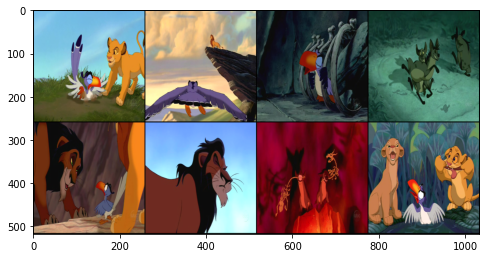

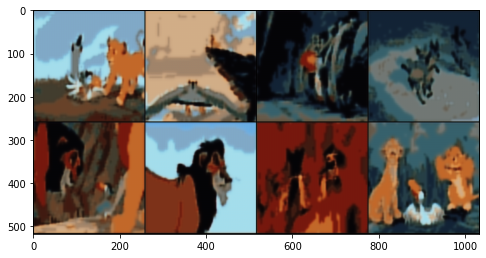

In [110]:
model = VectorQuantizedVAE(num_channels, hidden_size, k).to(device)
model.load_state_dict(torch.load('{0}/best.pt'.format(save_filename)))
model.eval()

real_batch = next(iter(DataLoader(dataset, batch_size=batch_size, shuffle=True)))
show_images(real_batch)
show_images(generate_samples(real_batch.detach().clone(), model))

In [109]:
writer.close()
!tensorboard --logdir=./runs --port=8898 --load_fast=false

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.8.0 at http://localhost:8898/ (Press CTRL+C to quit)
